In [1]:
# Performance Analysis Example Notebook
# =======================================
# This notebook demonstrates how to use the modular plotting functions
# to analyze backtest results in Jupyter

from nautilus_trader.model.objects import Currency
from nautilus_trader.core.nautilus_pyo3 import CurrencyType

import pandas as pd
import numpy as np
import yaml
from pathlib import Path
from algos.engine.performance_plots import (
    get_frequency_params,
    align_series,
    plot_balance_breakdown,
    plot_cumulative_returns,
    plot_rolling_sharpe,
    plot_risk_free_rate,
    plot_period_returns,
    plot_returns_distribution,
    plot_active_returns,
    plot_active_returns_heatmap,
    plot_rolling_ratios,
    plot_underwater,
    plot_portfolio_allocation,
)
from algos.engine.data_loader import CsvBarLoader

# ═══════════════════════════════════════════════════════════════════════
# 1. Load Backtest Results
# ═══════════════════════════════════════════════════════════════════════

# Option A: Load from MLflow run
import mlflow

run_id = "af69c1786641464caa7e5246c8bf3200"
exp_id = "459052638381111162"
client = mlflow.tracking.MlflowClient(tracking_uri="file:logs/mlruns")

cfg_path = Path("configs/config.yaml")
cfg = yaml.safe_load(cfg_path.read_text(encoding="utf-8"))
cfg["STRATEGY"]["PARAMS"]["currency"] = Currency(code='USD', precision=3, iso4217=840, name='United States dollar', currency_type = CurrencyType.FIAT ) #
data_loader = CsvBarLoader(cfg=cfg["STRATEGY"]["PARAMS"],adjust = cfg["MODEL"]["PARAMS"]["adjust"])

# Load positions and account data from MLflow artifacts
acc_pth = client.download_artifacts(run_id=run_id, path="account_report.csv")
pos_pth = client.download_artifacts(run_id=run_id, path="positions_report.csv")
positions = pd.read_csv(pos_pth, index_col = 0, parse_dates=True )
account_df = pd.read_csv(acc_pth, index_col = 0, parse_dates=True )

# Option B: Load directly from saved files
# account_df = pd.read_csv("logs/backtests/trial_X/account_report.csv", 
#                          index_col=0, parse_dates=True)

# Load benchmark and risk-free data
benchmark_returns = data_loader.benchmark_returns
risk_free_returns = data_loader.risk_free_df['risk_free']

# ═══════════════════════════════════════════════════════════════════════
# 2. Calculate Returns
# ═══════════════════════════════════════════════════════════════════════

freq = '1D'  # Your backtest frequency
freq_params = get_frequency_params(freq)

# Extract portfolio values
if 'currency' in account_df.columns:
    # Multi-currency case
    first_currency = account_df['currency'].iloc[0]
    portfolio_values = account_df[account_df['currency'] == "USD"]['total']
else:
    # Single currency case
    portfolio_values = account_df['total']  # or 'free', 'locked', etc.

# Resample and calculate returns
portfolio_values = portfolio_values.resample(freq_params['resample_freq']).last().ffill()
strategy_ret = portfolio_values.pct_change().fillna(0)

# ═══════════════════════════════════════════════════════════════════════
# 3. Align Series
# ═══════════════════════════════════════════════════════════════════════

strategy_ret, benchmark_ret, rf_ret = align_series(
    strategy_ret,
    benchmark_returns,
    risk_free_returns,
    freq_params['resample_freq']
)

print(f"Aligned series length: {len(strategy_ret)}")

# ═══════════════════════════════════════════════════════════════════════
# 4. Generate Individual Plots
# ═══════════════════════════════════════════════════════════════════════

output_dir = Path("analysis_output")
output_dir.mkdir(exist_ok=True)


c:\Users\gianc\Desktop\PYTHON\sapiens\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\gianc\AppData\Local\Temp\ipykernel_6704\1859740944.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  positions = pd.read_csv(pos_pth, index_col = 0, parse_dates=True )


Aligned series length: 28


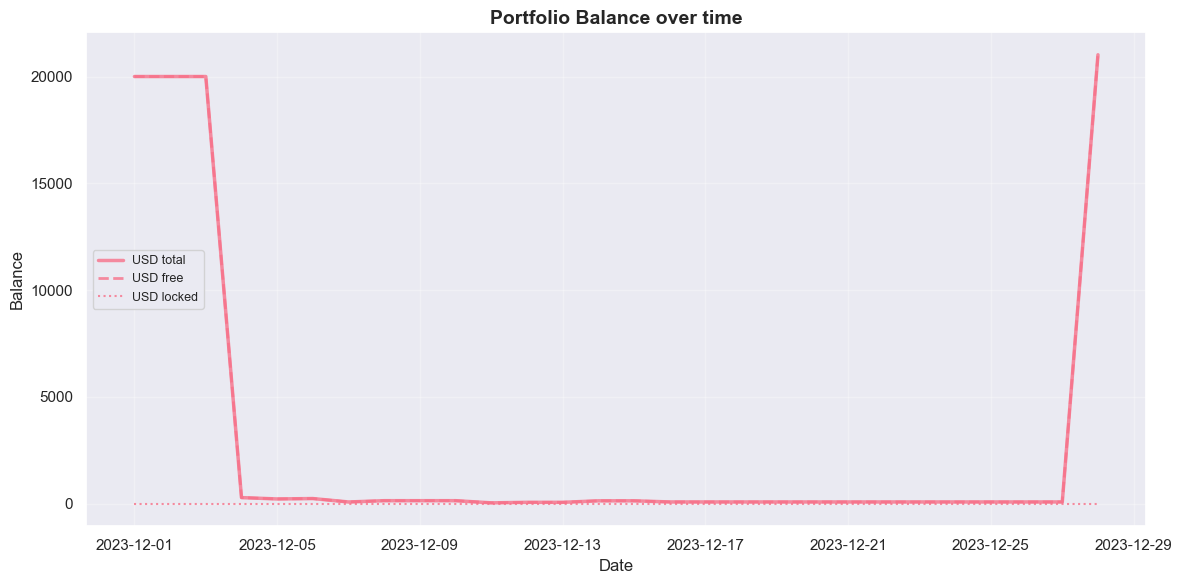

In [2]:

# Plot 1: Balance Breakdown
fig1 = plot_balance_breakdown(
    account_df=account_df,
    resample_freq=freq_params['resample_freq'],
    #save_path=output_dir / 'balance_breakdown.png'
)


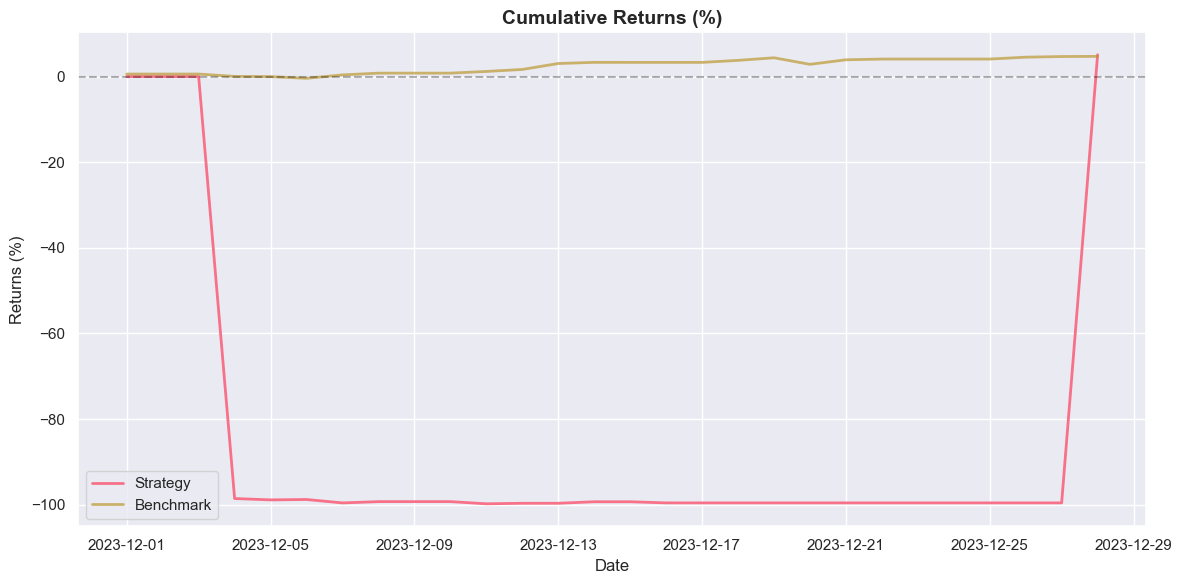

In [3]:

# Plot 2: Cumulative Returns
fig2 = plot_cumulative_returns(
    strategy_ret=strategy_ret,
    benchmark_ret=benchmark_ret,
    #save_path=output_dir / 'cumulative_returns.png'
)


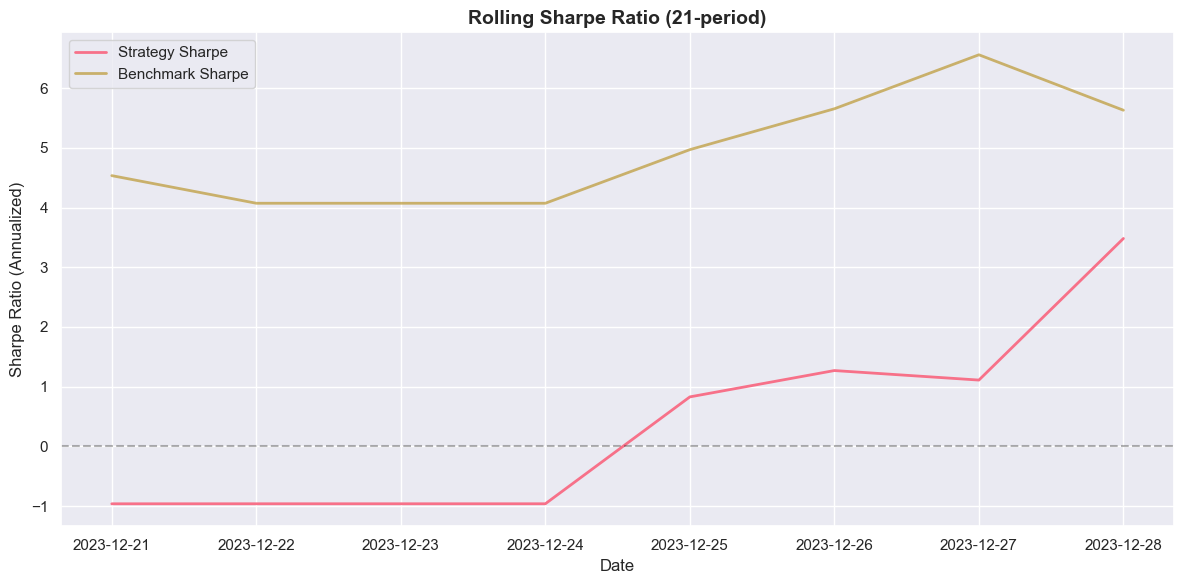

In [4]:

# Plot 3: Rolling Sharpe
window = max(10, int(freq_params['periods_per_year'] / 12))
fig3 = plot_rolling_sharpe(
    strategy_ret=strategy_ret,
    benchmark_ret=benchmark_ret,
    rf_ret=rf_ret,
    window=window,
    annualization_factor=freq_params['annualization_factor'],
    #save_path=output_dir / 'rolling_sharpe.png'
)


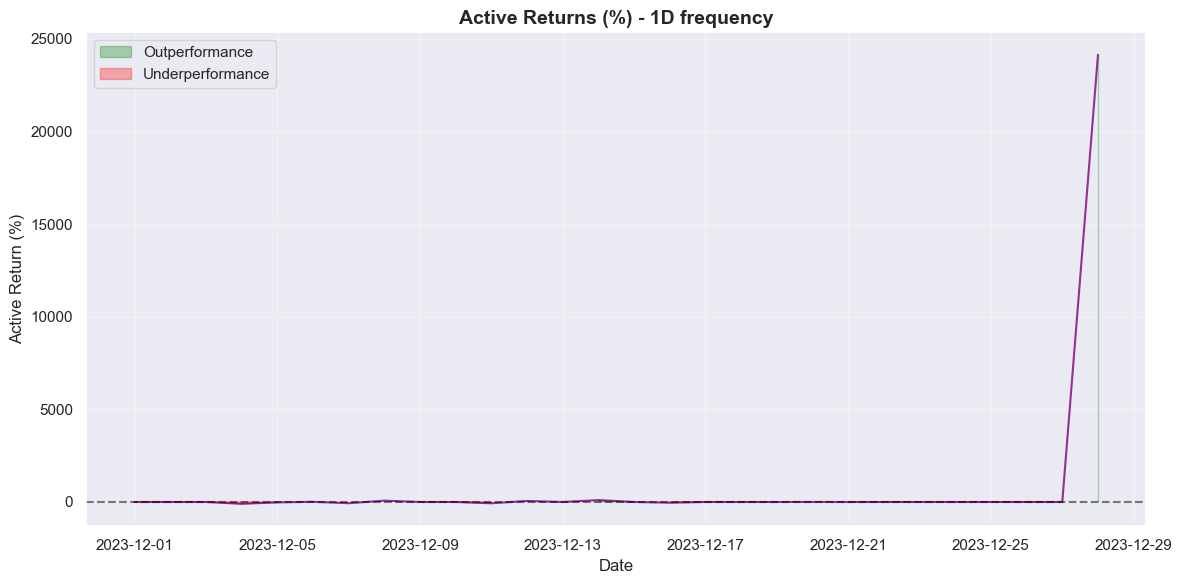

In [5]:

# Plot 4: Active Returns
fig4 = plot_active_returns(
    strategy_ret=strategy_ret,
    benchmark_ret=benchmark_ret,
    freq=freq,
    #save_path=output_dir / 'active_returns.png'
)


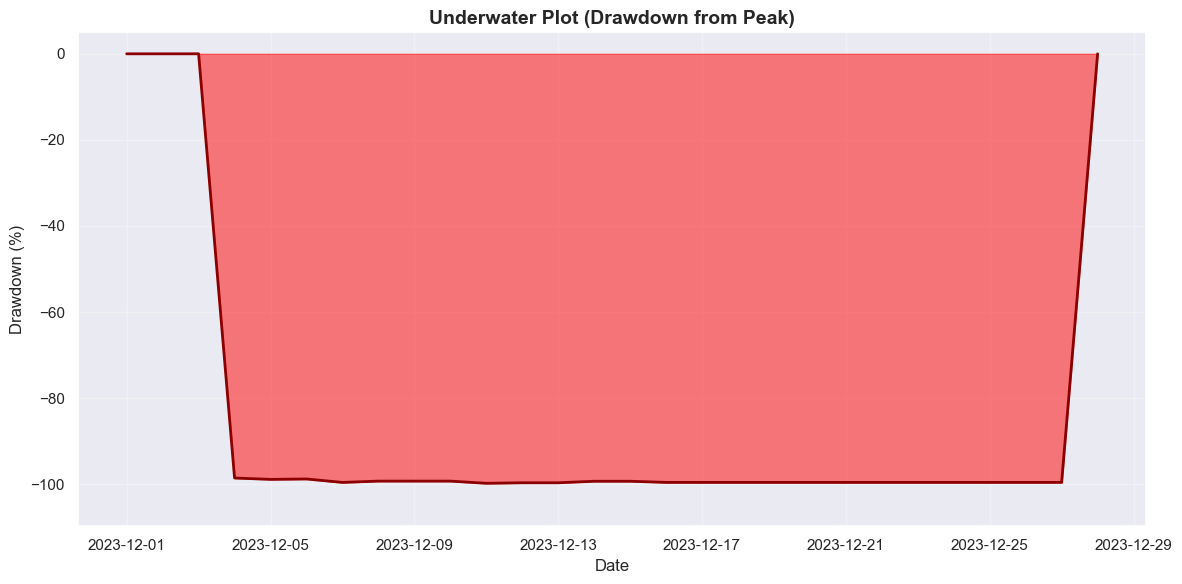

In [6]:

# Plot 5: Underwater (Drawdown)
fig5 = plot_underwater(
    strategy_ret=strategy_ret,
    #save_path=output_dir / 'underwater.png'
)


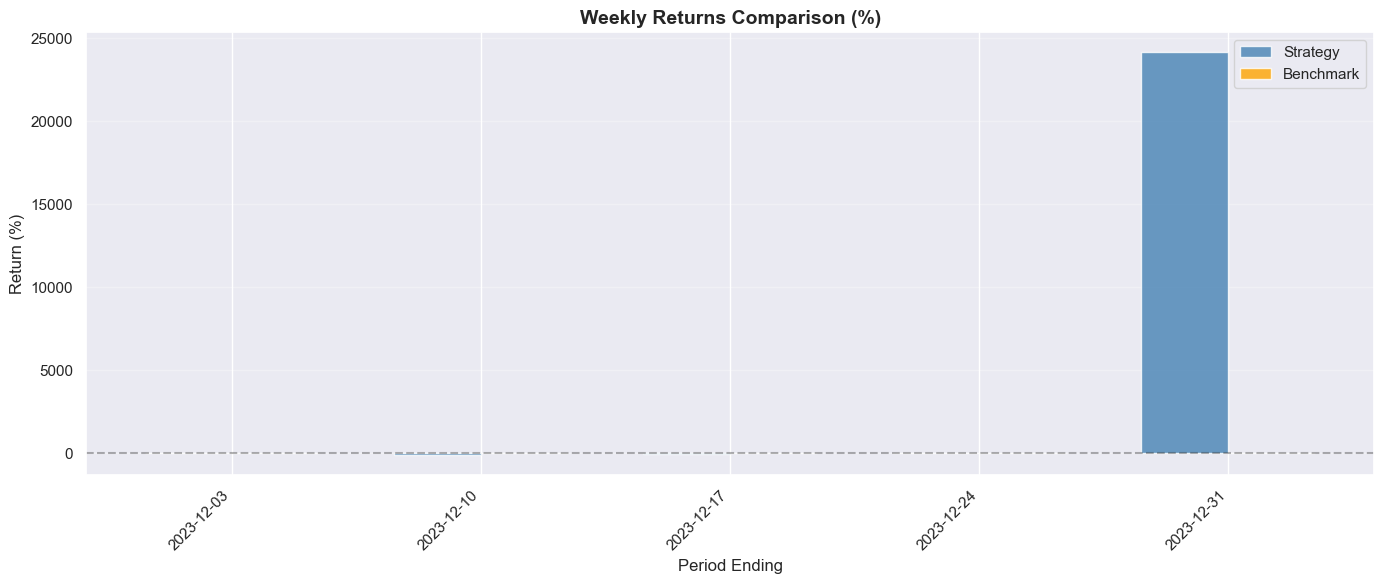

In [7]:

# Plot 6: Period Returns
if len(strategy_ret) >= 5:
    fig6 = plot_period_returns(
        strategy_ret=strategy_ret,
        benchmark_ret=benchmark_ret,
        agg_freq=freq_params['weekly_freq'],
        period_label='Weekly',
        #save_path=output_dir / 'period_returns.png'
    )


In [8]:

# Plot 7: Returns Distribution
fig7 = plot_returns_distribution(
    strategy_ret=strategy_ret,
    agg_freq=freq_params['monthly_freq'],
    period_label='Monthly',
    #save_path=output_dir / 'returns_distribution.png'
)


Insufficient data for returns distribution


<Figure size 640x480 with 0 Axes>

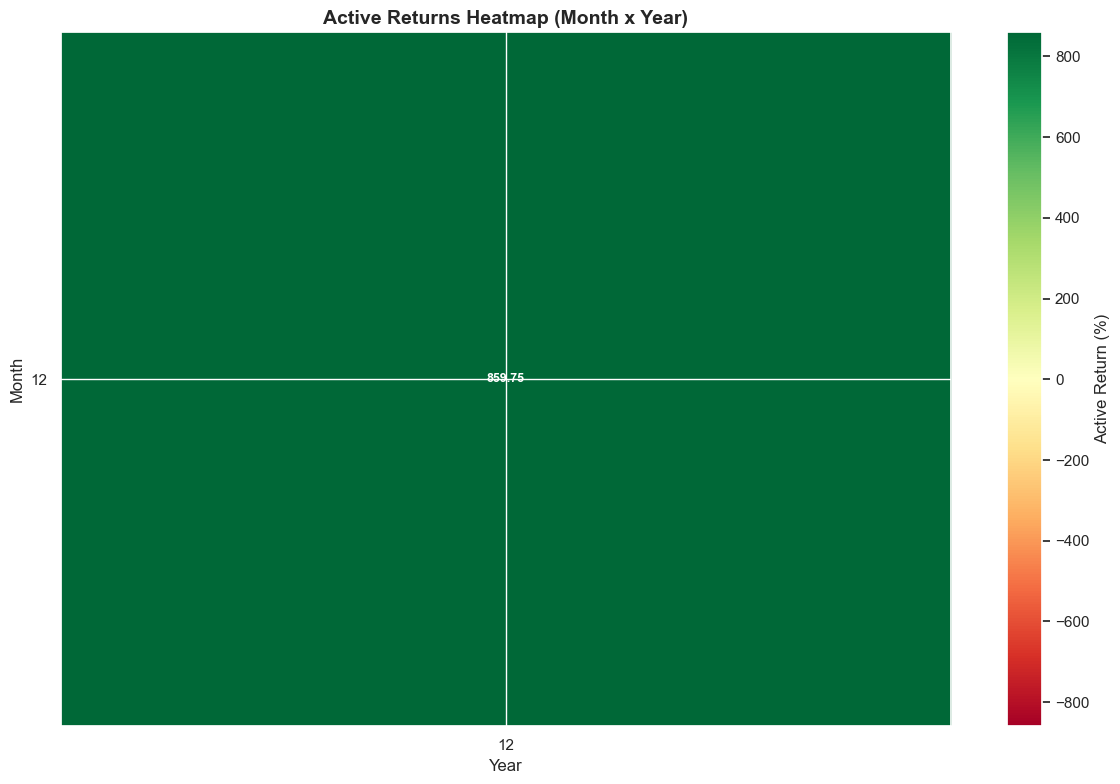

In [9]:

# Plot 8: Active Returns Heatmap (for daily data)
fig8 = plot_active_returns_heatmap(
    strategy_ret=strategy_ret,
    benchmark_ret=benchmark_ret,
    #save_path=output_dir / 'active_heatmap.png'
)


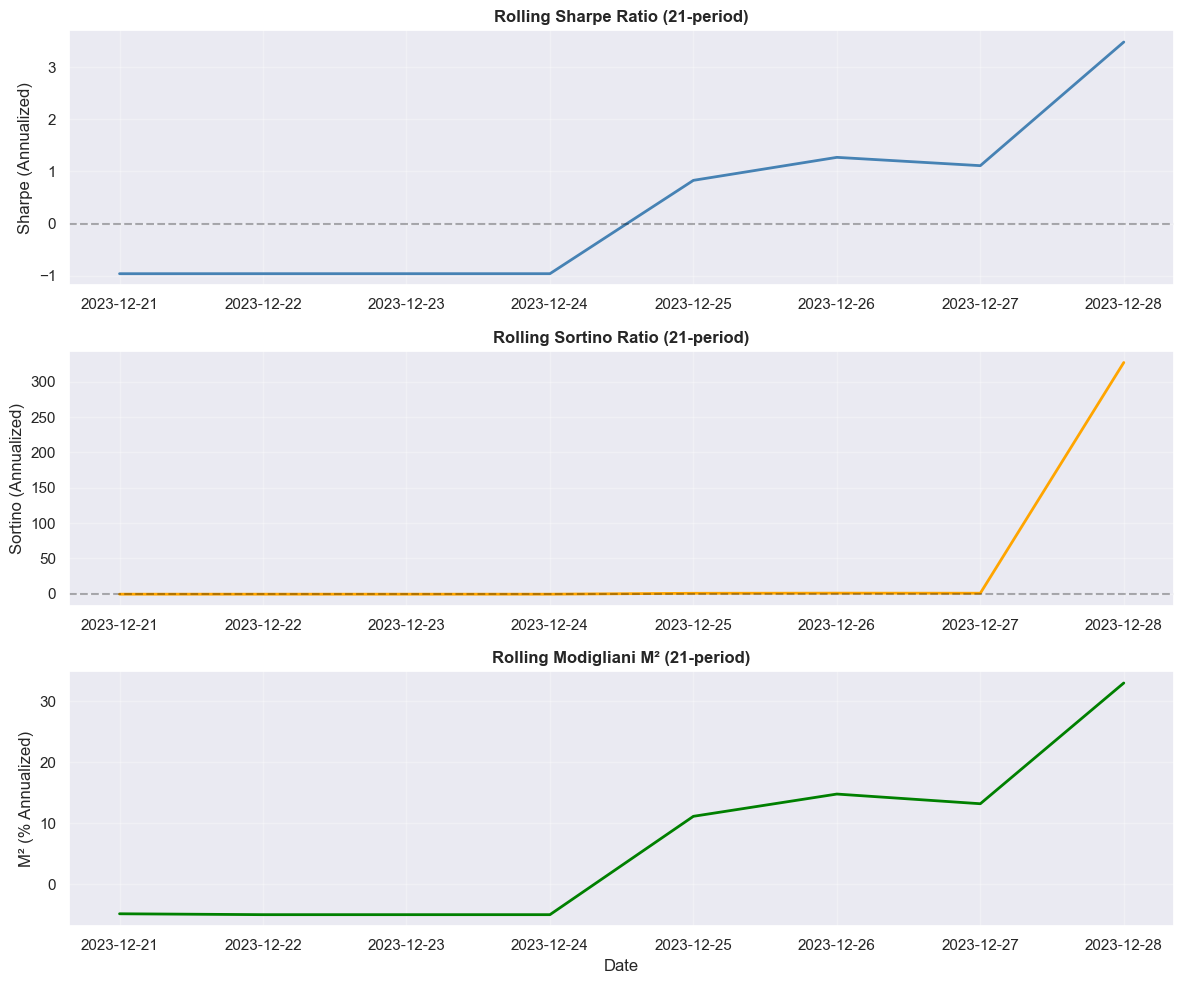

In [10]:

# Plot 9: Rolling Risk Ratios
fig9 = plot_rolling_ratios(
    strategy_ret=strategy_ret,
    benchmark_ret=benchmark_ret,
    rf_ret=rf_ret,
    window=window,
    periods_per_year=freq_params['periods_per_year'],
    annualization_factor=freq_params['annualization_factor'],
    #save_path=output_dir / 'rolling_ratios.png'
)


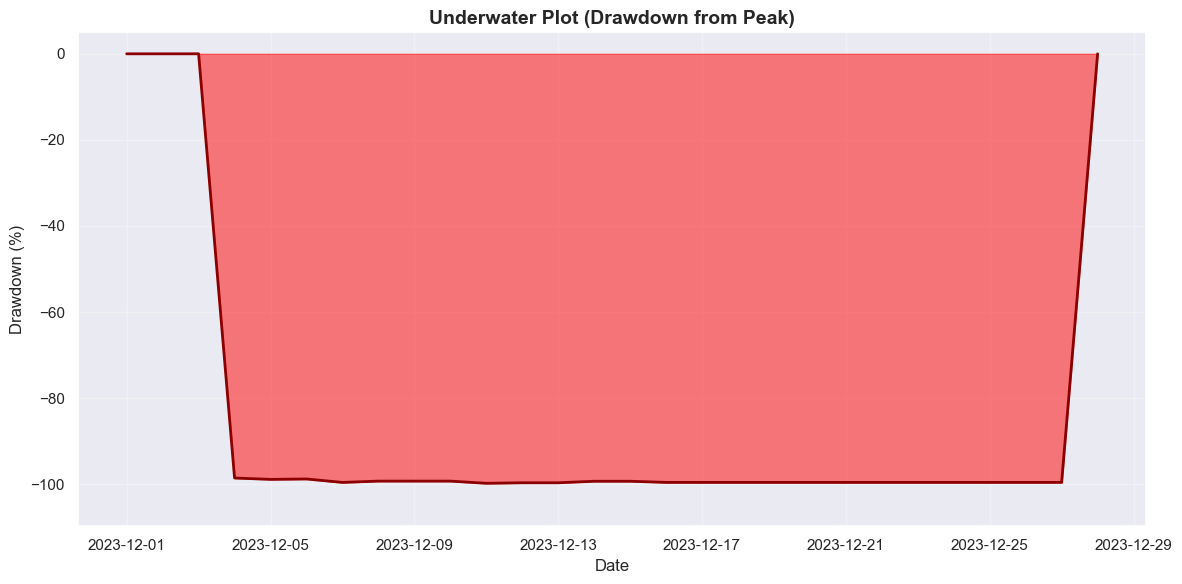

In [11]:

# Plot 10: Underwater Plot (Drawdown)
fig10 = plot_underwater(
    strategy_ret=strategy_ret,
    #save_path=output_dir / 'underwater_plot.png'
)


Index(['trader_id', 'strategy_id', 'instrument_id', 'account_id',
       'opening_order_id', 'closing_order_id', 'entry', 'side', 'quantity',
       'peak_qty', 'ts_init', 'ts_opened', 'ts_last', 'ts_closed',
       'duration_ns', 'avg_px_open', 'avg_px_close', 'commissions',
       'realized_return', 'realized_pnl', 'is_snapshot'],
      dtype='object')


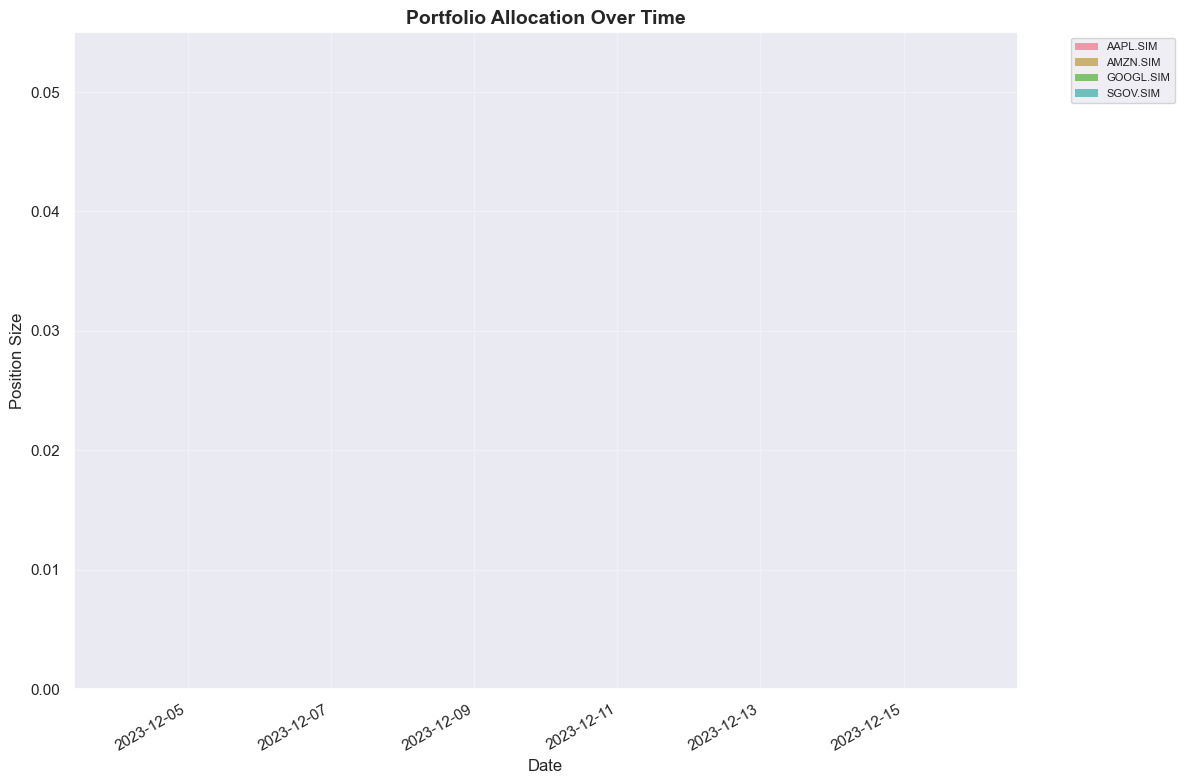

In [12]:
            

# Plot 11: Portfolio Allocation 
print(positions.columns)
fig11 = plot_portfolio_allocation(
    positions_df=positions,
    resample_freq=freq_params['resample_freq'],
    #save_path=output_dir / 'portfolio_allocation.png'
)


In [13]:
"""
# ═══════════════════════════════════════════════════════════════════════
# 5. Display in Notebook (Optional)
# ═══════════════════════════════════════════════════════════════════════

from IPython.display import Image, display

# Display saved images
for img_path in output_dir.glob("*.png"):
    print(f"\n{img_path.stem}:")
    display(Image(filename=str(img_path)))

# ═══════════════════════════════════════════════════════════════════════
# 6. Calculate Summary Statistics
# ═══════════════════════════════════════════════════════════════════════

# Annualized metrics
total_return = (1 + strategy_ret).prod() - 1
annualized_return = (1 + total_return) ** (freq_params['periods_per_year'] / len(strategy_ret)) - 1
annualized_vol = strategy_ret.std() * freq_params['annualization_factor']
sharpe_ratio = (strategy_ret.mean() - rf_ret.mean()) / strategy_ret.std() * freq_params['annualization_factor']

# Drawdown
cumulative = (1 + strategy_ret).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

# Win rate
winning_periods = (strategy_ret > 0).sum()
win_rate = winning_periods / len(strategy_ret)

summary_stats = pd.DataFrame({
    'Metric': [
        'Total Return (%)',
        'Annualized Return (%)',
        'Annualized Volatility (%)',
        'Sharpe Ratio',
        'Max Drawdown (%)',
        'Win Rate (%)',
        'Number of Periods'
    ],
    'Value': [
        f"{total_return * 100:.2f}",
        f"{annualized_return * 100:.2f}",
        f"{annualized_vol * 100:.2f}",
        f"{sharpe_ratio:.2f}",
        f"{max_drawdown * 100:.2f}",
        f"{win_rate * 100:.2f}",
        len(strategy_ret)
    ]
})

print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(summary_stats.to_string(index=False))

# ═══════════════════════════════════════════════════════════════════════
# 7. Export Results
# ═══════════════════════════════════════════════════════════════════════

# Save summary to CSV
summary_stats.to_csv(output_dir / 'performance_summary.csv', index=False)

# Save detailed time series
results_df = pd.DataFrame({
    'strategy_returns': strategy_ret,
    'benchmark_returns': benchmark_ret,
    'risk_free': rf_ret,
    'strategy_cumulative': (1 + strategy_ret).cumprod(),
    'benchmark_cumulative': (1 + benchmark_ret).cumprod()
})
results_df.to_csv(output_dir / 'detailed_returns.csv')

print(f"\nResults exported to: {output_dir}")
"""

'\n# ═══════════════════════════════════════════════════════════════════════\n# 5. Display in Notebook (Optional)\n# ═══════════════════════════════════════════════════════════════════════\n\nfrom IPython.display import Image, display\n\n# Display saved images\nfor img_path in output_dir.glob("*.png"):\n    print(f"\n{img_path.stem}:")\n    display(Image(filename=str(img_path)))\n\n# ═══════════════════════════════════════════════════════════════════════\n# 6. Calculate Summary Statistics\n# ═══════════════════════════════════════════════════════════════════════\n\n# Annualized metrics\ntotal_return = (1 + strategy_ret).prod() - 1\nannualized_return = (1 + total_return) ** (freq_params[\'periods_per_year\'] / len(strategy_ret)) - 1\nannualized_vol = strategy_ret.std() * freq_params[\'annualization_factor\']\nsharpe_ratio = (strategy_ret.mean() - rf_ret.mean()) / strategy_ret.std() * freq_params[\'annualization_factor\']\n\n# Drawdown\ncumulative = (1 + strategy_ret).cumprod()\nrunning_